In [2]:
import torch
import copy
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Add the parent directory to the Python path - bad practice, but it's just for the example
import sys
sys.path.append("/home/heydari/FHHI-XAI/")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.datasets.DLR_dataset import DatasetDLR
from src.plot_crp_explanations import plot_explanations, plot_one_image_explanation
from src.minio_client import MinIOClient
from LCRP.models import get_model 
from LCRP.utils.crp_configs import ATTRIBUTORS, CANONIZERS, VISUALIZATIONS, COMPOSITES

import logging
# Suppress specific noisy libraries if needed
logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("numba").setLevel(logging.WARNING)



DEBUG:matplotlib.pyplot:Loaded backend inline version unknown.


In [3]:
# Define transformation (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])
# Load dataset
root_dir = "../data/General_Flood_v3/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_name = "pidnet"
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "../models/flood_s_best_pidnet_modified.pt"

# Loading unet with path to checkpoint
model = get_model(model_name="pidnet" , device=device ,ckpt_path = ckpt_path , classes=2)

model.augment = False
output_dir = "../src/output/crp/pidnet_flood"

Loading checkpoint from: ../models/flood_s_best_pidnet_modified.pt


# CRP

In [ ]:
# run_analysis(model_name, model, dataset, output_dir=output_dir, device=device)

In [4]:


x = dataset[3][0].unsqueeze(0)
model.eval()



# Without canonizer
out_plain = model(x.clone())

attribution = ATTRIBUTORS[model_name](model)
composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
condition = [{"y": 1}]
attr = attribution(copy.deepcopy(x).requires_grad_(), condition, composite, record_layer=["conv1.0"],
                        init_rel=1)

out_canon = attr.prediction

print("Output difference:", (out_plain - out_canon).abs().max())
print("Classes:", out_plain.argmax(), out_canon.argmax())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

torch.Size([3, 480, 480])
MEMORY STARTING: 0.03GB (max: 0.03GB)
MEMORY AFTER FIGURE CREATION: 0.03GB (max: 0.03GB)
MEMORY BEFORE SEGMENTATION ATTR: 0.03GB (max: 0.03GB)


/home/heydari/.virtualenvs/TEMA-FHHI-PY/lib/python3.10/site-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Error during explanation: Input type (torch.cuda.FloatTensor) and bias type (torch.FloatTensor) should be the same


RuntimeError: Input type (torch.cuda.FloatTensor) and bias type (torch.FloatTensor) should be the same

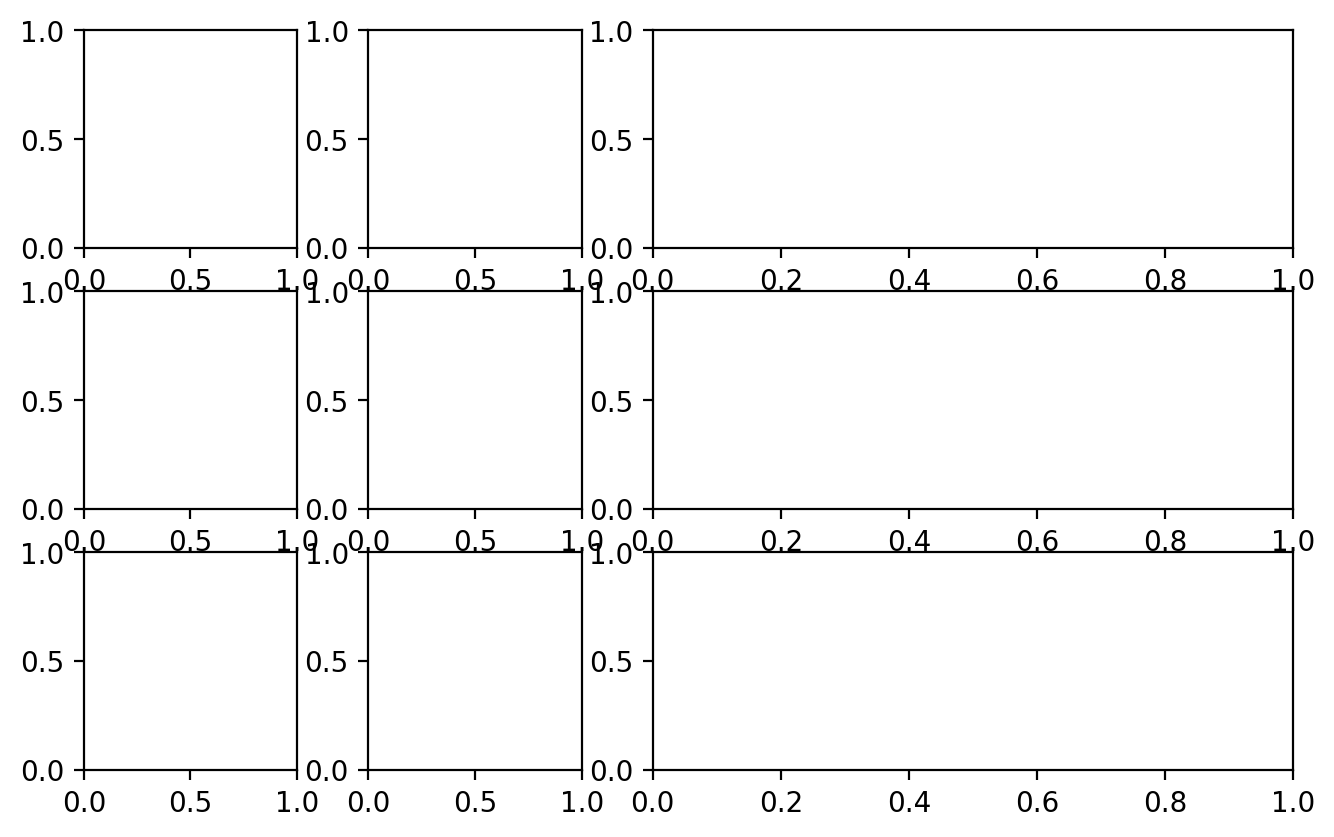

In [5]:
# Setting up main parameters
class_id = 1
sample_id = 0
n_concepts = 3
n_refimgs = 12
layer = "layer2.0.conv1"
# layer = "layer1.1.conv1"
mode = "relevance"
prediction_num = 0

# if failing, try to restart the notebook and do not run analysis again, go directly to plotting
plot_explanations(model_name, model, dataset, sample_id, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)

# PCX

In [ ]:
import os
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from datetime import datetime
from tqdm import tqdm
from torchvision.utils import make_grid

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

In [ ]:
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
# cc = ChannelConcept()

# layer_names = get_layer_names(model, [torch.nn.Conv2d])
# # Setting up CRP 
# attribution = ATTRIBUTORS[model_name](model)
# composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
# condition = [{"y": 1}]  
# fv = VISUALIZATIONS[model_name](attribution,
#                                 dataset,
#                                 layer_names,
#                                 preprocess_fn=lambda x: x,
#                                 path=output_dir,
#                                 max_target="max")

# # Runs faster on MPS
# device = "mps"
# model.to(device)
# model.eval()

# start = datetime.now()

# activations = {}
# attributions = {}
# for i, (x, y) in enumerate(tqdm(dataset)):
#     x = x.to(device).requires_grad_()
#     condition = [{"y": 1}]
#     attr = attribution(x.unsqueeze(0), condition, composite, record_layer=layer_names)

#     for layer_name in layer_names:
#         if layer_name in attr.activations.keys():
#             if layer_name not in attributions.keys():
#                 attributions[layer_name] = []
#                 activations[layer_name] = []
#             activations[layer_name].append(attr.activations[layer_name].amax((-2, -1)))
#             attributions[layer_name].append(cc.attribute(attr.relevances[layer_name], abs_norm=True))

# for layer_name in layer_names:
#     if layer_name in attribution.keys():
#         attributions[layer_name] = torch.cat(attributions[layer_name])
#         activations[layer_name] = torch.cat(activations[layer_name])    
#         folder = f"output/pcx/pidnet_flood/{layer_name}/"
#         # attributions[layer_name] = torch.cat(attributions[layer_name])
#         # activations[layer_name] = torch.cat(activations[layer_name])
#         os.makedirs(folder, exist_ok=True)
#         np.save(folder + "attributions", attributions[layer_name].cpu().numpy())
#         np.save(folder + "activations", activations[layer_name].cpu().numpy())
# end = datetime.now()

In [ ]:
# Loading
layer_names = get_layer_names(model, [torch.nn.Conv2d])
layer_name = layer_names[10]
print(layer_name)
folder = f"output/pcx/pidnet_flood/{layer_name}/"
attributions = torch.from_numpy(np.load(folder + "attributions.npy"))
activations = torch.from_numpy(np.load(folder + "activations.npy"))
indices = np.arange(len(dataset))

num_prototypes = {
   
}

In [ ]:
from umap import UMAP


embedding_attr = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_attr = embedding_attr.fit_transform(attributions.detach().cpu().numpy())
x_attr, y_attr = X_attr[:, 0], X_attr[:, 1]

embedding_act = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_act = embedding_act.fit_transform(activations.detach().cpu().numpy())
x_act, y_act = X_act[:, 0], X_act[:, 1]

In [ ]:
from scipy import stats
from sklearn.mixture import GaussianMixture

N_PROTOTYPES = 8

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(5, 3), facecolor='white')
for i, X in enumerate([X_attr, X_act]):
    x, y = X[:, 0], X[:, 1]
    xmin = x.min() - 2
    xmax = x.max() + 2
    ymin = y.min() - 2
    ymax = y.max() + 2
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values, 0.5)
    Z = np.reshape(kernel(positions).T, X.shape).T
    axes[i].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
    axes[i].scatter(x, y, s=3, alpha=0.7, zorder=1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(["attributions", "activations"][i])
    axes[i].plot([1], y[1], 'ko', markersize=5, label="test image")
    axes[i].legend()


prototypes = []
gmms = []
for i, (X, emb) in enumerate([(attributions, embedding_attr), (activations, embedding_act)]):
    gmms.append(GaussianMixture(n_components=N_PROTOTYPES, random_state=0).fit(X.detach().cpu().numpy()))
    prototypes.append(gmms[-1].means_)
    mean = emb.transform(gmms[-1].means_)
    axes[i].scatter(mean[:, 0], mean[:, 1], s=30, c="#1B4365", zorder=2, label="prototypes")
    for k, prot in enumerate(mean):
        axes[i].text(prot[0], prot[1], k, fontsize=4, color="white", ha="center", va="center")
    axes[i].legend()

plt.tight_layout()
fig.show()

In [ ]:
proto_attr = prototypes[0]

distances = np.linalg.norm(attributions[:, None, :].detach().cpu() - proto_attr, axis=2)
prototype_samples = np.argsort(distances, axis=0)[:8]
prototype_samples = indices[prototype_samples]

fig, axs = plt.subplots(1, N_PROTOTYPES, figsize=(1*N_PROTOTYPES, 8), dpi=200, facecolor='white')


for i in range(N_PROTOTYPES):
    grid = make_grid(
        [dataset[prototype_samples[j][i]][0] for j in range(8)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f"{i}")


In [ ]:
from src import plot_pcx_explanations
print(dir(plot_pcx_explanations)) 

In [ ]:
from src.plot_pcx_all import plot_pcx_explanations
plot_pcx_explanations("pidnet", model.to("cpu"), dataset, sample_id=100, n_concepts=5,n_refimgs=12, num_prototypes=5, layer_name=layer_name, ref_imgs_path="output/ref_imgs_pidnet/", output_dir_pcx="output/pcx/pidnet_flood/", output_dir_crp="output/crp/pidnet_flood/")

In [ ]:
print(layer_name)

In [ ]:
x, y = dataset[200]
print("Sample shape:", x.shape)


In [ ]:
dummy = torch.randn(1, 3, 256, 256)  # try with 3 channels first
output = model(dummy)
print("Output shape:", output.shape)
